# Basisdaten und Statistik

Die für dich notwendigen Daten hast du bereits im letzten Teil heruntergeladen.

Aber sind diese Daten für deinen Anwendungszweck überhaupt geeignet? Das zeigt dir eine statistische Auswertung. Das mag langweilig klingen, ist aber für das anschließend folgende Machine Learning enorm wichtig. Sehr viele Projekte scheitern nämlich, weil die Datenqualität einfach nicht stimmt.

Die Datenqualität kannst du auch selbst verbessern, indem du z.B. fehlende Daten erkennst oder solche, bei denen es sich offensichtlich um Fehler (Outlier) handelt. Dieser Vorgang wird oft das *Data Cleansing* bezeichnet. Wenn du Texte verarbeiten möchtest, spielt z.B. hier die Landessprache auch eine große Rolle. Mehr darüber erfährst du im NLP-Kurs.

Häufig wirst du mit zeitabhängigen Daten arbeiten. Diese *Zeitreihen* solltest du genau analysieren, um zu verhindern, dass du mit veralteten Daten arbeitest.

## Statistik des Heise Newstickers

Wie du im letzten Teil gesehen hast, kann man relativ einfach die Daten des Heise Newstickers herunterladen. Wie das genau geht, kannst du im NLP-Videokurs sehen. Dort erkläre ich dir auch, wie man die Texte analysiert und die Anzahl der Wörter (Tokens) bestimmt.

Hier gehen wir davon aus, dass du das schon erledigt hast (oder jemand anders für dich). Die Daten sind schon über die Monate aggregiert und stehen die als CSV-Datei zur Verfügung. Du weißt schon, wie du das mit `pandas` einlesen kannst:

In [1]:
import pandas as pd
heise_monthly = pd.read_csv("heise-monthly.csv", parse_dates=["month"], index_col="month")
heise_monthly

,count,tokens
month,,
1996-04-01,30,133.766667
1996-05-01,24,146.375000
1996-06-01,16,132.500000
1996-07-01,24,159.375000
1996-08-01,41,195.756098
...,...,...
2020-08-01,1022,517.211350
2020-09-01,1148,498.890244
2020-10-01,1216,501.518914


Für jeden Monat findest du hier die Anzahl der Artikel und die mittlere Anzahl an Tokens. Am einfachsten kannst du dir einen `DataFrame` mit `describe` erklären lassen:

In [2]:
heise_monthly.describe()

,count,tokens
count,297.000000,297.000000
mean,737.993266,339.596078
std,296.632849,100.884368
min,12.000000,132.500000
25%,662.000000,280.851369
50%,816.000000,333.746089
75%,921.000000,428.087539
max,1252.000000,551.237016


Das ist eine sog. [Five Number Summary](https://en.wikipedia.org/wiki/Five-number_summary), in der du wesentliche statistische Eigenschaften findest. Du kannst dir das natürlich auch als Grafik ausgeben lassen, zunächst die Anzahl der Artikel:

<AxesSubplot:xlabel='month'>

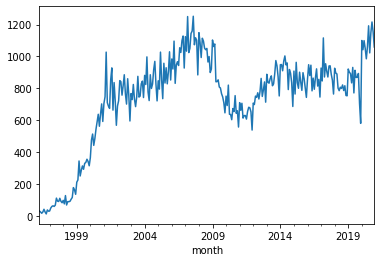

In [3]:
heise_monthly["count"].plot()

Das sieht gut aus, die Anzahl war zwar um 2005/2006 etwas höher, hat sich aber (etwa durch Corona) im Jahr 2020 wieder ziemlich erhöht. Wie sieht es mit der Länge der Artikel in Wörtern (Tokens) aus:

<AxesSubplot:xlabel='month'>

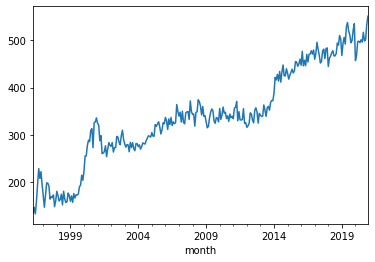

In [4]:
heise_monthly["tokens"].plot()

Die Heise-Autoren sind wirklich fleißig und schreiben immer längere Texte!

Natürlich haben wir noch nicht die fachliche Domäne überprüft. So könnte es ja sein, dass der Newsticker nur noch Werbung enthält. Die inhaltliche Analyse ist deutlich schwieriger, dazu findest du auch im NLP-Kurs (sehr) viel mehr.

Du kannst an dieser Stelle jedenfalls festhalten, dass die Daten statistisch gut geeignet sind als Basis für *Machine Learning*. Sie sind aktuell, die Textlänge entwickelt sich positiv. Das ist bei weitem nicht immer so!

## Statistik der Konsumindikatoren

In [5]:
!pip install eurostat

Alle Statistikdaten haben bei Eurostat ein Kürzel. In diesem Beispiel beschäftigst du dich mit den *Konsumindikatoren*, diese tragen das Kürzel `ei_bsco_m`. Es handelt sich dabei um sog. *business and consumer surveys*, die monatlich verdichtet sind (alternativ könntest du die auch auf das Quartal aggregiert herunterladen). Eine genauere Erklärung findest du [hier](https://ec.europa.eu/eurostat/cache/metadata/en/ei_bcs_esms.htm). 

Das Herunterladen der Daten ist nun sehr einfach:

In [6]:
import eurostat
df = eurostat.get_data_df("ei_bsco_m")

Betrachte im nächsten Schritt die Daten:

In [7]:
df

,indic,s_adj,unit,geo\time,2021M07,2021M06,2021M05,2021M04,2021M03,2021M02,...,1980M10,1980M09,1980M08,1980M07,1980M06,1980M05,1980M04,1980M03,1980M02,1980M01
0,BS-CSMCI,NSA,BAL,AL,-12.9,-13.6,-15.6,-18.1,-19.8,-17.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BS-CSMCI,NSA,BAL,AT,0.2,-0.6,-0.9,-10.5,-4.1,-8.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BS-CSMCI,NSA,BAL,BE,2.9,4.1,1.1,-3.5,-3.0,-5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BS-CSMCI,NSA,BAL,BG,-16.5,-18.4,-22.2,-20.0,-23.5,-29.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BS-CSMCI,NSA,BAL,CY,-23.5,-10.1,-15.8,-19.0,-22.6,-27.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,BS-UE-NY,SA,BAL,SE,-16.2,-17.7,-4.5,4.3,13.9,16.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
902,BS-UE-NY,SA,BAL,SI,21.8,9.3,21.4,45.4,40.3,35.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,BS-UE-NY,SA,BAL,SK,24.3,22.3,32.5,46.1,58.9,57.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
904,BS-UE-NY,SA,BAL,TR,33.4,28.5,36.5,36.0,27.5,30.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`geo\time` ist eine etwas unglückliche Bezeichnung, hier ist nur das Land gemeint, das kannst du einfach umbenennen:

### Datenstruktur anpassen

In [8]:
df = df.rename(columns={"geo\\time": "country"})

Ebenso etwas merkwürdig sind die Monatsnamen in Form von `2021M04` etc., die du auch besser durch ein `datetime`-Objekt in Python ersetzt:

In [9]:
from datetime import datetime
df.columns = [datetime.strptime(f.split("M")[0] + "-" + f.split("M")[1] + "-01", "%Y-%m-%d")
                if f.startswith("20") or f.startswith("19") else f for f in df.columns]

Du interessiert dich nun für die Zeitentwicklung des Konsumindikators *Konsumentenvertrauen* in Deutschland:

### Zeitreihen

In [10]:
bs_de = df[(df["indic"] == "BS-CSMCI") & (df["s_adj"] == "SA") & (df["country"] == "DE")]
bs_de = bs_de[[c for c in bs_de.columns 
                     if (isinstance(c, datetime) and c.year>=2000)]]
bs_de

,2021-07-01,2021-06-01,2021-05-01,2021-04-01,2021-03-01,2021-02-01,2021-01-01,2020-12-01,2020-11-01,2020-10-01,...,2000-10-01,2000-09-01,2000-08-01,2000-07-01,2000-06-01,2000-05-01,2000-04-01,2000-03-01,2000-02-01,2000-01-01
41,-2.0,-1.2,-4.3,-7.9,-8.2,-12.0,-14.0,-10.5,-11.6,-9.5,...,-8.6,-6.4,-3.4,-4.5,-5.1,-1.7,-4.8,-4.3,-3.8,-5.9


Das Ergebnis kannst du plotten und hast dann auch eine Zeitreihe wie oben. Du kannst die Effekte der Finanzkrise und der Corona-Krise sehr gut erkennen. Damit hast du sichergestellt, dass du den richtigen Indikator betrachtest! 

<AxesSubplot:>

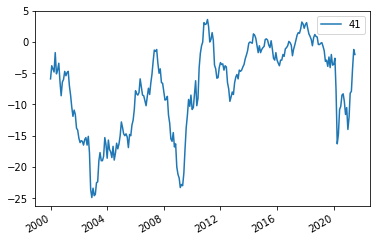

In [11]:
bs_de.T.plot()

In Deutschland sehen die Indikatoren gut aus, im nächsten Schritt untersuchst du die Vollständigkeit.

### Vollständigkeit der Daten

Dafür betrachtest du die saisonjustierten Daten zu einem beswtimmten Zeitpunkt, allerdings für alle Länder gleichzeitig. Die `pivot`-Funktion kennst du schon, die ist hier sehr nützlich:

In [12]:
indic_country = df[df["s_adj"] == "SA"].pivot(index="country", columns="indic", values=datetime(2021, 6, 1))
indic_country

indic,BS-CSMCI,BS-FS-LY,BS-FS-NY,BS-GES-LY,BS-GES-NY,BS-MP-NY,BS-MP-PR,BS-PT-LY,BS-PT-NY,BS-SFSH,BS-SV-NY,BS-SV-PR,BS-UE-NY
country,,,,,,,,,,,,,
AL,-14.2,-13.0,3.1,-20.5,3.5,-50.7,-65.7,-3.6,-19.0,2.5,-45.6,-46.3,6.3
AT,-2.0,-7.6,5.5,-54.9,9.6,-15.4,6.5,33.3,44.7,29.4,18.7,19.0,-13.8
BE,2.8,-4.4,4.5,-38.2,18.1,-7.1,12.2,52.8,21.5,29.4,25.3,-21.3,9.8
BG,-19.7,-16.4,-5.7,-52.6,-20.5,-36.1,-23.0,39.2,17.3,19.2,-22.3,-12.1,15.5
CY,-13.4,-12.9,0.3,-56.0,-10.7,-30.3,-31.9,-13.0,-12.4,17.3,-32.6,-19.0,13.2
CZ,-4.9,-4.1,4.8,-54.1,-10.8,-9.4,-8.4,17.2,46.4,34.9,16.5,-10.7,8.6
DE,-1.2,0.4,3.8,-40.1,-3.2,-5.9,-8.4,33.3,44.8,30.1,14.9,14.0,11.7
DK,5.9,5.1,11.6,-14.5,5.0,2.1,-7.6,0.4,30.0,36.2,42.9,54.9,-11.3
EA19,-3.3,-8.0,2.1,-49.2,3.4,-10.7,-9.8,24.7,27.1,20.8,7.7,NaN,11.4


In der Tabelle fallen dir schon die `NaN` auf, noch besser kannst du das über eine Heatmap erkennen:

<AxesSubplot:xlabel='indic', ylabel='country'>

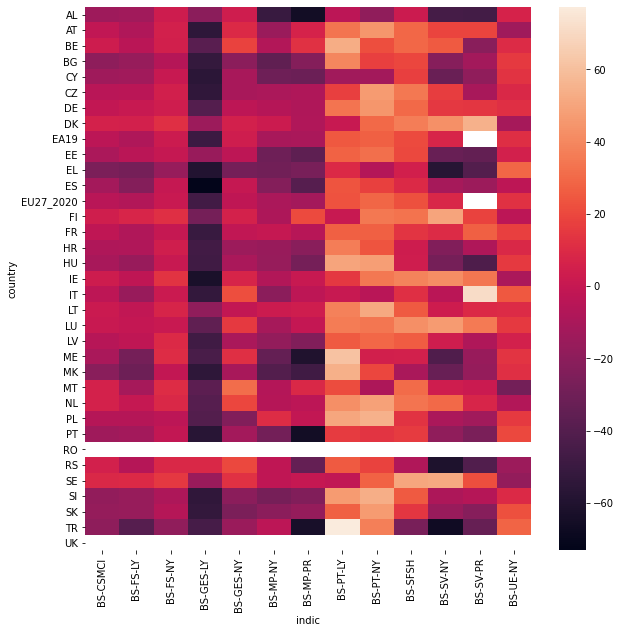

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.heatmap(indic_country)

In Rumänien sind für diesen Zeitpunkt gar keine Daten gemeldet worden, ebenso im UK. Hier musst du also mit der Analyse vorsichtig sein. Für den Euro-Raum und die gesamte EU fehlt noch der Indikator `BS-SV-PR`.

### Korrelation der Daten

Im letzten Teil dieses Notebooks betrachtest du die Abhängigkeiten der Indikatoren zueinander. Oftmals wirst du es mit Größen zu tun haben, die gar nicht unabhängig voneinander sind. Um das zu ermitteln, gibt es in Python und `pandas` leistungsfähige Funktionen.

Du schaust dir dazu die Konsumindikatoren für Deutschland ab dem Jahr 2000 an:

In [14]:
# Jahre ab 2000
columns_2000 = [c for c in df.columns if isinstance(c, datetime) and (c.year>=2000)]

de = df[(df["s_adj"] == "SA") & (df["country"] == "DE")].set_index("indic")[columns_2000].transpose()
de

indic,BS-CSMCI,BS-FS-LY,BS-FS-NY,BS-GES-LY,BS-GES-NY,BS-MP-NY,BS-MP-PR,BS-PT-LY,BS-PT-NY,BS-SFSH,BS-SV-NY,BS-SV-PR,BS-UE-NY
2021-07-01,-2.0,-1.0,2.4,-31.5,-2.3,-6.9,-10.3,35.5,43.6,29.2,14.3,14.6,9.9
2021-06-01,-1.2,0.4,3.8,-40.1,-3.2,-5.9,-8.4,33.3,44.8,30.1,14.9,14.0,11.7
2021-05-01,-4.3,-2.1,2.1,-44.8,-9.0,-8.2,-7.3,24.6,35.1,30.6,16.9,17.1,27.4
2021-04-01,-7.9,-3.4,1.4,-49.8,-20.1,-9.4,-1.6,20.8,35.0,30.2,15.8,16.6,37.6
2021-03-01,-8.2,-5.1,2.0,-56.6,-20.5,-9.1,-8.5,16.1,38.0,32.2,15.9,20.0,40.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-05-01,-1.7,0.4,7.5,-8.2,-5.7,-8.9,-8.2,17.0,40.1,11.9,18.1,48.0,3.4
2000-04-01,-4.8,-3.9,5.3,-15.0,-10.7,-9.8,-14.1,18.9,36.6,11.4,13.2,45.8,16.2
2000-03-01,-4.3,-3.8,6.7,-16.7,-11.0,-9.1,-10.9,21.9,44.7,10.0,15.9,47.5,17.3
2000-02-01,-3.8,-1.9,5.9,-14.7,-11.0,-8.3,-11.3,17.7,42.6,12.0,17.0,44.6,18.2


Die Abhängigkeit jeweils zweier Indikatoren kannst du nun als *Scatterplot* darstellen, am besten geht das mit `seaborn`:

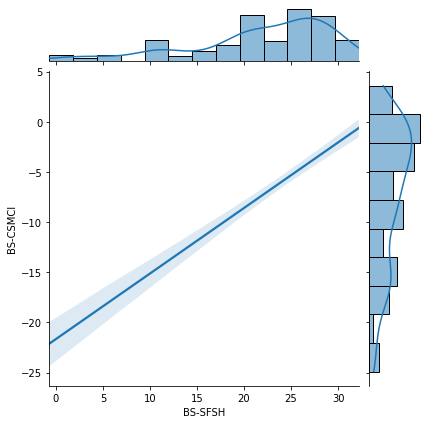

In [15]:
sns.jointplot(x=de["BS-SFSH"], y=de["BS-CSMCI"], scatter=False, kind="reg")

In der Grafik kannst du erkennen, dass die Indikatoren stark voneinander abhängig sind. Wenn du diese später als Features verwenden willst, musst du sehr aufpassen, dass es dadurch nicht zum sog. *Overfitting* kommt.

Wenn du noch mehr Abhängigkeiten auf einmal darstellen möchtest, kannst du das in einem Gitter anordnen:

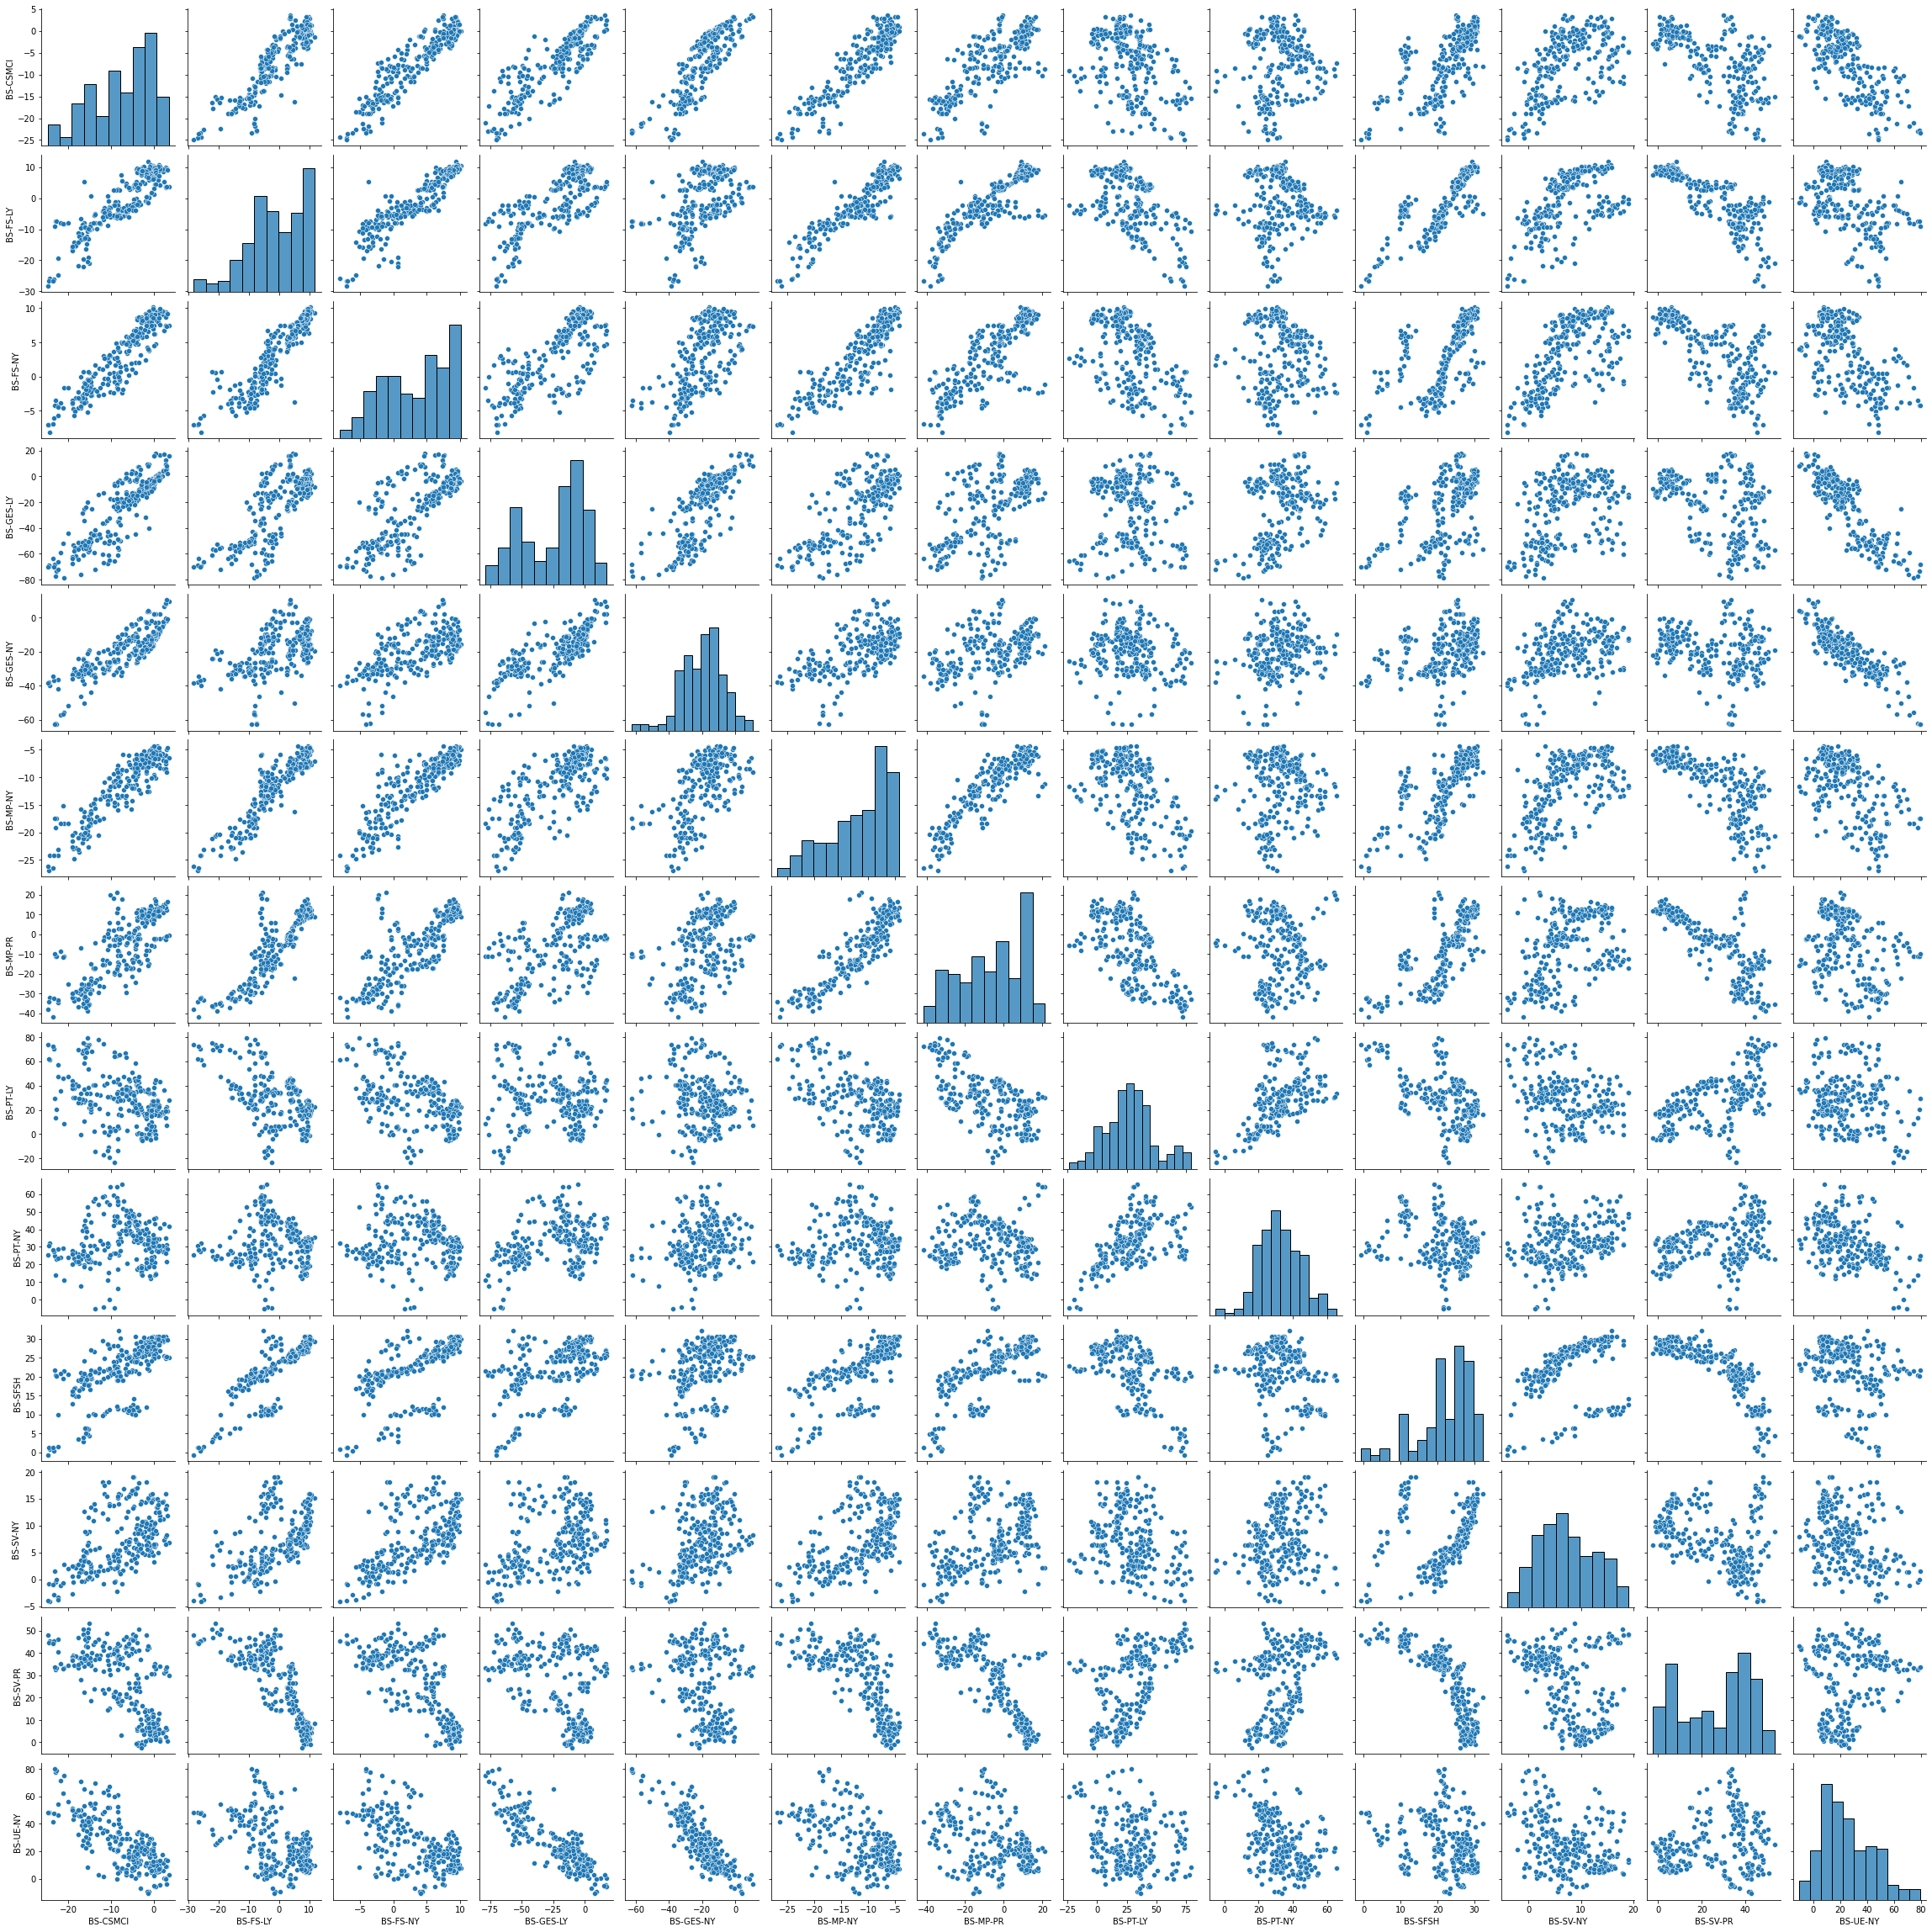

In [16]:
sns.pairplot(de)

Zugebenermaßen sind das ziemlich viele Plots. Bei einigen kannst du eine (positive) Korrelation erkennen, bei anderen eine Antikorrelation. Ein gutes Maß dafür ist das sog. [Pearson-R](https://de.wikipedia.org/wiki/Korrelationskoeffizient#Voraussetzungen_f%C3%BCr_die_Pearson-Korrelation), das du für alle Permutationen aus Indikatoren berechnen kannst.

In [17]:
from scipy.stats import linregress
from itertools import permutations
res = []
for (i1, i2) in permutations(de.columns, 2):
    res.append({ "Indikator 1": i1, "Indikator 2": i2, "Pearson R": linregress(de[i1], de[i2]).rvalue})

Passenderweise gibt uns `pandas` die mit den stärksten Korrelationen und Antikorrelationen gleich aus:

In [18]:
pd.DataFrame(res).sort_values("Pearson R")

,Indikator 1,Indikator 2,Pearson R
47,BS-GES-LY,BS-UE-NY,-0.879794
147,BS-UE-NY,BS-GES-LY,-0.879794
59,BS-GES-NY,BS-UE-NY,-0.866082
148,BS-UE-NY,BS-GES-NY,-0.866082
22,BS-FS-LY,BS-SV-PR,-0.821498
...,...,...,...
4,BS-CSMCI,BS-MP-NY,0.910123
24,BS-FS-NY,BS-CSMCI,0.919581
1,BS-CSMCI,BS-FS-NY,0.919581
61,BS-MP-NY,BS-FS-LY,0.921289


## Korrelationen nicht unterschätzen

Es ist wichtig, dass du die Korrelationen kennst, damit du nicht mit zu vielen Variablen in deinem Machine Learning-Projekt arbeitest. Sonst besteht die Gefahr des Overfittings.